<table>
    <tr>
        <td><img src='../SystemLink_icon.png' /></td>
        <td ><h1><strong>NI SystemLink Analysis Automation</strong></h1></td>
    </tr>
</table>

This notebook is an example for how you can analyze your data with NI SystemLink Analysis Automation. It forms the core of the analysis procedure, which includes the notebook, the query, and the execution parameters (parallel or comparative). The [procedure is uploaded to Analysis Automation](https://www.ni.com/documentation/en/systemlink/latest/analysis/creating-anp-with-jupyter/). The output is a report in form of PDF documents or HTML pages. 
<br>
<hr>

## Prerequisites
Before you run this example, you need to [create a DataFinder search query](https://www.ni.com/documentation/en/systemlink/latest/datanavigation/finding-data-with-advanced-search/) in Data Navigation to find the example files (e.g. 'TR_M17_QT_42-1.tdms'). Save this query on the server.
<hr>

## Summary

This example exercises the SystemLink TDMReader API to access bulk data (see `data_api`) and/or descriptive data (see `metadata_api`). When the notebook executes, Analysis Automation provides data links which the API uses to access content.

It also shows how to select channels from two channel groups and display the data in two graphs.

The channel values from each channel group populate arrays, which you can use to further analyze your data in mathematical analyses and plot them in a graph.

Furthermore, the example uses two procedure parameters that write a comment to the first graph and select a channel to display in the second graph (refer to __Plot Graph__ below).



<hr>


## Imports

This example uses the `TDMReader` API to work with the bulk data and meta data of the given files. `Matplotlib` is used for plotting the graph. The `scrapbook` is used to set and display the results in the analysis procedure results list. 


In [1]:
import systemlink.clients.nitdmreader as tdmreader
metadata_api = tdmreader.MetadataApi()
data_api = tdmreader.DataApi()

import matplotlib.pyplot as plt

import scrapbook as sb

In [2]:
def get_property(element, property_name):
    """Gets a property of the given element.
    
    The element can be a file, channel group, or channel.
    
    Args:
        element: Element to get the property from.
        property_name: Name of the property to get.
        
    Returns:
        The according property of the element or ``None`` if the property doesn't exist.
    """
    return next((e.value for e in element.properties.properties if e.name == property_name), None)


## Retrieve Metadata with a Data Link

A data link is the input for each __Analysis Automation procedure__ that uses a query to collect specific data items. A `data_link` contains a list of one or more elements that point to a list of files, channel groups, or channels (depending on the query result type).

This example shows how the Metadata API accesses the `file_info` structure from the file, through the `groups`, and down to the `channels` level.

This example calculates the absolute minimum and absolute maximum value of all channels in each group and displays these values in the report.

In [3]:
data_links = ni_analysis_automation["data_links"]
file_ids = [d["fileId"] for d in data_links]
file_infos = await metadata_api.get_multiple_file_info(tdmreader.FileList(file_ids))
file_info = file_infos[0]

test_file_name = get_property(file_info, "name")
program_name = get_property(file_info, "Test~Procedure")

group_names = []
channels = []
formatted_properties = []

for group in file_info.groups:
    group_names.append(group.name)
    channels.append(group.channels)
    max_values_of_group = []    
    min_values_of_group = []    
    mean_values_of_group = []    

    for channel in group.channels:
        minimum = float(get_property(channel, "minimum") or "NaN")
        maximum = float(get_property(channel, "maximum") or "NaN")
        mean_values_of_group.append((minimum + maximum) / 2)
        max_values_of_group.append(maximum)
        min_values_of_group.append(minimum)

        
    # Calculate statistical values from metadata
    abs_min = max(max_values_of_group)
    abs_max = min(max_values_of_group)
    abs_mean = sum(mean_values_of_group) / float(len(mean_values_of_group))
    formatted_properties.append(f"Absolute Maximum: {abs_max:.3f} °C"+
                                f",Absolute Minimum: {abs_min:.3f} °C"+
                                f",Mean Value: {abs_mean:.3f} °C")
    

## Define Notebook Parameters.

a) In a code cell (*called __parameters cell__*), define the parameters. Fill in the needed values/content parameters in the code cell below. E.g.

   **Defined parameters:**
   - `comment_group_1`: Writes a comment into the box of the first group.<br> 
   (Default value = `Checked`)
   - `shown_channel_index`: Any valid channel index of the second group. This channel is plotted in the second graph. <br>
   (Default value = `2`)

   Your code may look like the following:

In [4]:
comment_group_1 = "Checked"
shown_channel_index = 2

b) Select this code cell (*__parameters cell__*) and open on the __Property Inspector__ panel on the right sidebar to add the parameters, their default values, to the __Cell Metadata__ code block. For example, your code may look like the following:

```json
{
    "papermill": {
        "parameters": {
            "comment_group_1": "Checked",
            "shown_channel_index": 2
        }
    },
    "tags": [
        "parameters"
    ]
}
```

<hr>

You can use the variables of the __parameters__ cell content in all code cells below.

The following cell populates the info box of the plot with the parameter. 

In [5]:
formatted_properties[1] += f",Parameter: {comment_group_1}"
formatted_properties[0] += f",Channel #: {shown_channel_index}"

## Retrieve Bulk Data with a Data Link

Use the TDMReader API to work with bulk data. There are multiple ways for retrieving the data. The access path used in this example shows you how to loop over all groups and over all channels within the groups. The resulting channel specifiers (`chn_specs`) are used in the next step to `query` the bulk data and retrieve all channel `values` from the queried data.   

In [6]:
bulk_data = []
file_id = data_links[0]['fileId']

for group in file_info.groups:
    chn_specs = []
    
    for channel in group.channels:
        channel_specifier = tdmreader.OneChannelSpecifier(
            file_id=file_id, 
            group_name=group.name, 
            channel_name=channel.name)
        chn_specs.append(channel_specifier)

    xy_chns = tdmreader.ChannelSpecificationsXyChannels(y_channels=chn_specs)
    channel_specs = tdmreader.ChannelSpecifications(xy_channels=[xy_chns])
    query = tdmreader.QueryDataSpecifier(channel_specs)
    data = await data_api.query_data(query)
    
    # get numeric y-data
    y_channels = data.data[0].y
    values = list(map(lambda c: c.numeric_data, y_channels))
    bulk_data.append(values)


## Plot Graph

The next two cells plot a graph with two areas and two sub plots, using the Python `matplotlib.pyplot` module as `plt`.


In [7]:
# Helper method and constant for plotting data 
curr_fontsize = 18
axis_lable_fontsize = curr_fontsize - 5

def plot_area(subplot, area_bulk_data, area_meta_data, enable_channel_selector, area_properties):
    """ Plot a sub print area of a figure 
     :param subplot:                 Object of the plot print area 
     :param area_bulk_data:          Channel bulk data to print
     :param area_meta_data:          Channel metadata (name, properties, ...)
     :param enable_channel_selector: True, when property shown_channel_index should be used
     :param area_properties:         String with comma-separated parts as content for the info box area
                                     e.g.: "Absolute Maximum: 12.6 °C,Absolute Minimum: -22.3 °C"
    """
    # Place a text box below the legend
    subplot.text(1.05, 0.0, area_properties.replace(",", "\n"),
                transform=subplot.transAxes, ha="left", va="bottom")
    subplot.grid(True)
    subplot.set_xlabel('Time [s]', fontsize=axis_lable_fontsize)
    
    unit = get_property(area_meta_data[0], "unit_string")
    subplot.set_ylabel('Amplitudes ['+unit+']', fontsize=axis_lable_fontsize)
    i = 0
    for channel in area_meta_data:
        if (enable_channel_selector):
            if (i == (shown_channel_index - 1)):
                subplot.plot(area_bulk_data[i], label=channel.name)    # Lable => name of the curve = channel 
        else:
            subplot.plot(area_bulk_data[i], label=channel.name)        # Lable => name of the curve = channel 
        i += 1

    # Place a legend to the right of this subplot.
    subplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=axis_lable_fontsize)


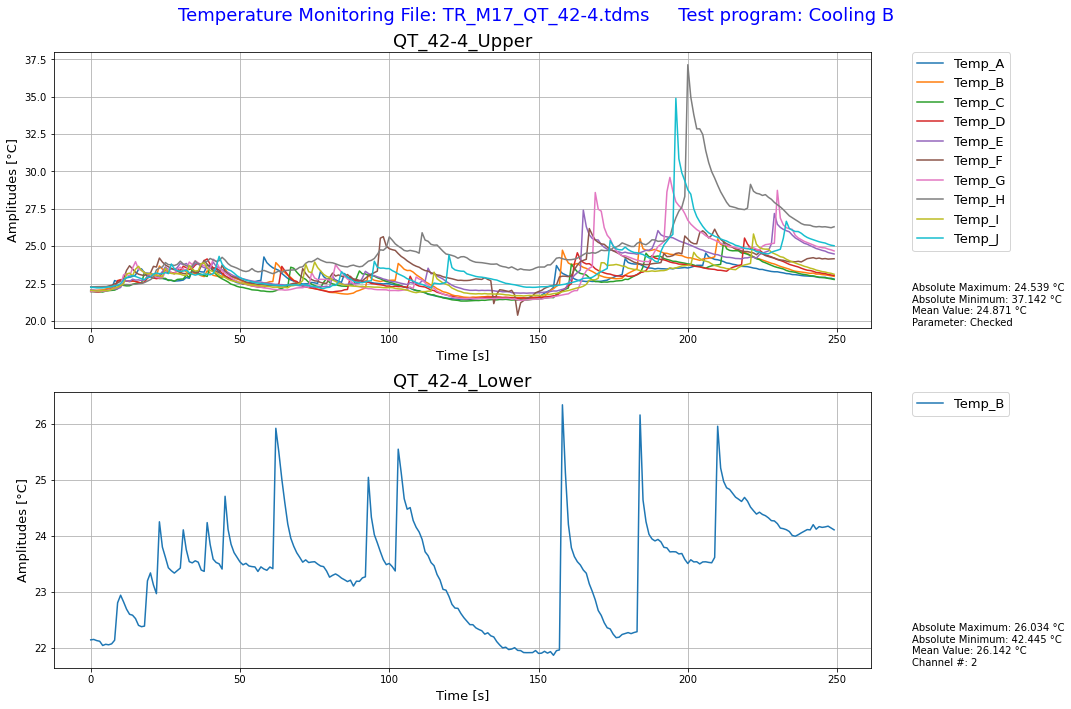

In [8]:
# Create plot and print data 
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
fig.suptitle ('Temperature Monitoring File: '+ test_file_name + '     Test program: ' + program_name, fontsize=curr_fontsize, color='blue')

ax1.set_title(group_names[1], fontsize=curr_fontsize)
plot_area(ax1, bulk_data[1],  channels[1], False, formatted_properties[1])
ax2.set_title(group_names[0], fontsize=curr_fontsize)
plot_area(ax2, bulk_data[0], channels[0], True, formatted_properties[0])

plt.tight_layout()
plt.show()

## Add Result Summary

Each Scrap recorded with `sb.glue()` is displayed for each procedure on the __History__ tab in Analysis Automation. 

In [9]:
sb.glue("File", test_file_name)
sb.glue("Test", program_name)
sb.glue("Comment", comment_group_1)
sb.glue("Displayed Channel #", shown_channel_index)